In [1]:
cd ..

/home/martinsevilla/topology_langevin


### Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle as pkl
import networkx as nx
from functools import partial

from langevin import langevin as lang
import langevin.utils as ut

# np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float64)

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### Data creation

In [3]:
seed = 15
torch.manual_seed(seed)
np.random.seed(seed)
graph_type = "deezer_ego"

model_files = {
    "deezer_ego": ("edp_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
                   "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi": ("edp_gnn/exp/barabasi_albert_diff_nodes/edp-gnn_barabasi_albert_[47, 49, 51, 53]__Jun-13-10-13-20_999031/models/" + 
                 "barabasi_albert_[47, 49, 51, 53]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi_smaller": ("edp_gnn/exp/barabasi_albert_diff_nodes_small/edp-gnn_barabasi_albert_[15, 17, 19, 21, 23]__Aug-07-15-50-45_2986529/models/" + 
                         "barabasi_albert_[15, 17, 19, 21, 23]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")
}

if graph_type == "deezer_ego":
    with open("edp_gnn/data/test_deezer_ego.pkl", "rb") as f:
        graphs = pkl.load(f)
        g = graphs[np.random.randint(len(graphs))]
        A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
        A = torch.tensor(A)
    max_nodes = 25
elif graph_type == "barabasi":
    g = nx.dual_barabasi_albert_graph(50, 2, 4, 0.5, seed=seed)
    max_nodes = 53
elif graph_type == "barabasi_smaller":
    g = nx.dual_barabasi_albert_graph(20, 2, 4, 0.5, seed=seed)
    max_nodes = 23

# A = torch.randint(0, 2, (5, 5)).double()
# A = torch.triu(A) + torch.triu(A, 1).T
# A.fill_diagonal_(0.0)
model_file = model_files[graph_type]
A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
A = torch.tensor(A)
# Number of nodes
p = A.shape[0]
# Number of measurements
n = 5
# Filter parameter distribution
theta_dist = torch.distributions.Normal(0.5, 0.5)
theta = theta_dist.sample()
# Variance of the noise
sigma_e = 1
# Known fraction of the matrix
p_unknown = 0.5

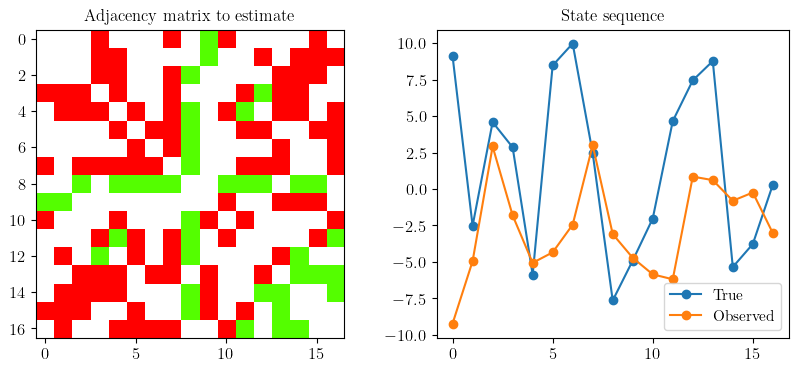

In [4]:
# Dynamics matrix
F = ut.heat_diffusion_filter(A, theta)
# L = ut.compute_laplacian(A)
e_dist = torch.distributions.Normal(0, sigma_e)

# Generate state and measurement sequence
X = torch.empty((p, n)).uniform_(-10, 10) # * torch.empty((p, n)).bernoulli_(0.8)
Y = F @ X + e_dist.sample((p, n))

# Generate unknown adjacency matrix
A_nan = ut.create_partially_known_graph(A, p_unknown)
known_idxs = torch.where(~ torch.isnan(A_nan))
unknown_idxs = torch.where(torch.isnan(A_nan))

A_plot = A.clone()
A_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_plot[known_idxs[1], known_idxs[0]] = torch.nan

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('Adjacency matrix to estimate')
ax[1].plot(X.T.cpu()[np.random.randint(n)], "-o", label="True")
ax[1].plot(Y.T.cpu()[np.random.randint(n)], "-o", label="Observed")
ax[1].set_title('State sequence')
ax[1].legend()
plt.show()

### KLF

In [5]:
sigmas = torch.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
steps = 300
num_samples = 1

model = ut.load_model(model_file)
A_score_model = ut.score_edp_wrapper(model, A.shape[0], len(sigmas), max_nodes=max_nodes)
# A_score_model = lambda A, _: torch.zeros(A.shape)

langevin_est = lang.LangevinEstimator(h_theta=ut.heat_diffusion_filter,
                                      A_score_model=A_score_model,
                                      # theta_prior_dist=theta_dist,
                                      theta_fixed=theta,
                                      sigma_e=sigma_e)

A_samples = torch.zeros((A.shape[0], A.shape[0], num_samples))
for i in range(num_samples):
    langevin_est.langevin_estimate(A_nan=A_nan, X=X, Y=Y, 
                                   sigmas_sq=sigmas ** 2, epsilon=epsilon, steps=steps, temperature=0.5,
                                   projection_method="copy", clip_A_tilde=True, true_A=A)
    A_samples[:, :, i] = langevin_est.A_tilde.clone()

Real theta: 0.22493684354160365
Estimated theta: tensor(0.2249, device='cuda:0')
AUCROC: 0.959375


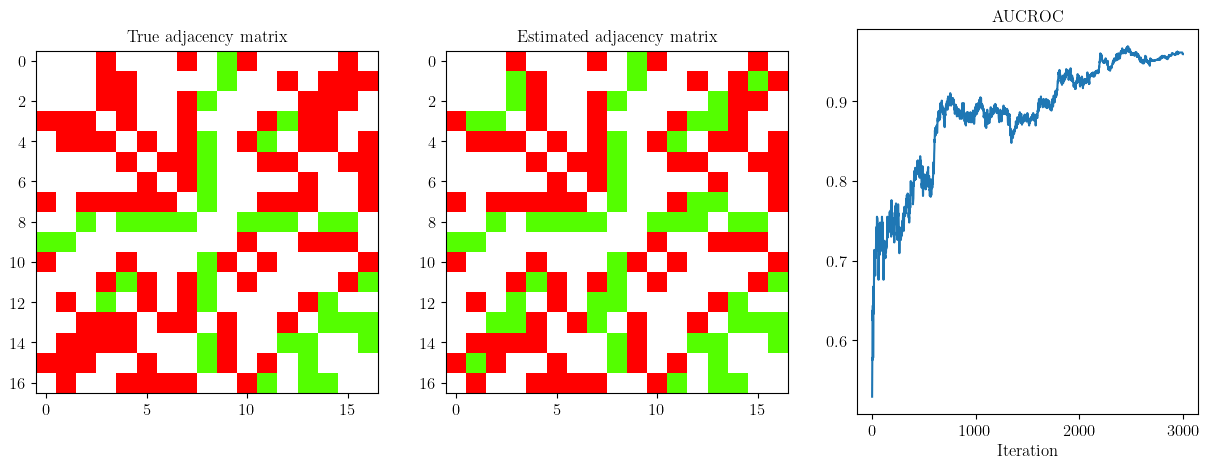

In [7]:
theta_est = langevin_est.theta_tilde
A_est = A_samples.mean(dim=-1)
roc, threshold = ut.compute_aucroc(A, A_est, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_est >= threshold).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta.item())
print("Estimated theta:", theta_est)
print("AUCROC:", roc)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')

ax[2].set_xlabel("Iteration")
ax[2].set_title("AUCROC")
ax[2].plot(langevin_est.metrics["aucroc"].cpu())

plt.show()

AUCROC: 0.8916666666666666


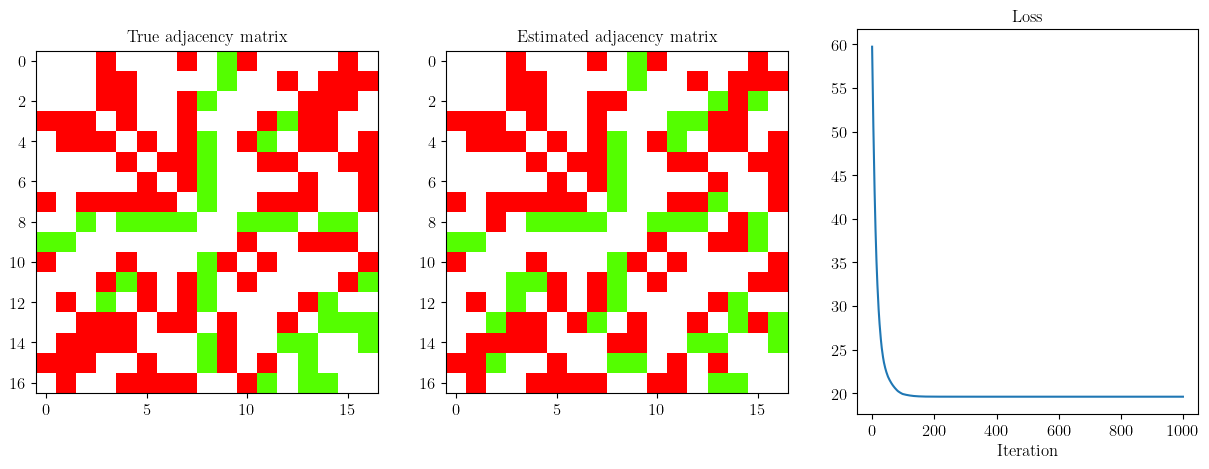

In [8]:
adam_est = lang.AdamEstimator(h_theta=partial(ut.heat_diffusion_filter, theta=theta), 
                              sigma_e=sigma_e, 
                              lr=0.01, n_iter=1000)
A_adam, loss_hist = adam_est.adam_estimate(A_nan, X, Y)

roc, threshold = ut.compute_aucroc(A, A_adam, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_adam >= threshold).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("AUCROC:", roc)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')
 
ax[2].set_xlabel("Iteration")
ax[2].set_title("Loss")
ax[2].plot(loss_hist)

plt.show()

In [16]:
# %lprun -f klf.kalman_langevin_estimate klf.kalman_langevin_estimate(sigmas_sq=sigmas ** 2, epsilon=epsilon, steps=steps, temperature=1.0)